In [1]:
%tensorflow_version 1.x
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

import gym
import numpy as np
import random
import matplotlib.pyplot as plt
import math
from collections import deque
from keras import Sequential
from keras.layers import Dense
from keras.optimizers import adam
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
class DQN(object):

    """ Implementation of deep q learning algorithm """

    def __init__(self, action_space, state_space):

        self.action_space = action_space
        self.state_space = state_space
        self.epsilon = 1
        self.epsilon_min = .01
        self.epsilon_decay = .999
        self.discount_factor = 1
        self.learning_rate = 0.001
        self.batch_size = 96
        self.memory = deque(maxlen = 10000)
        self.model = self.build_model()

    def build_model(self):

        # Our model will be a convolutional neural network. 
        # The network is trying to predict the expected return of taking each action given the current state of the environment.
        # It has two outputs, representing Q(state,left) and Q(state,right).

        model = Sequential()
        model.add(Dense(24, input_shape=(self.state_space,), activation='relu'))
        model.add(Dense(24, activation='relu'))
        model.add(Dense(self.action_space, activation='linear'))
        model.compile(loss = 'mse', optimizer = adam(lr = self.learning_rate))
        return model

    def remember(self, state, action, reward, next_state, done):

        # It stores the memory that the agent observes, allowing us to reuse this data later

        self.memory.append((state, action, reward, next_state, done))

    def act(self, state):

        # To balance between exploration and exploitation, a epsilon-greedy policy is introduced.
        # It is a decaying probability percentage which the learning algorithm uses to choose between. 
        # picking random action (exploration) or greedy action based on existing knowledge (exploitation).

        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

        if random.uniform(0, 1) <= self.epsilon: # exploration
            return env.action_space.sample()
        else:
            act_values = self.model.predict(state) # exploitation
            return np.argmax(act_values[0])

    def replay(self, step):
        
        # Agent experiences replay memory during training. Replay memory will be selected randomly,
        # so that a batch of tranining samples are decorrelted. It has been shown that random sampling greatly stabilizes 
        # and improves the DQN training procedure.
      
        if len(self.memory) < self.batch_size:
            return

        minibatch = random.sample(self.memory, self.batch_size)
        states = np.array([i[0] for i in minibatch])
        actions = np.array([i[1] for i in minibatch])
        rewards = np.array([i[2] for i in minibatch])
        next_states = np.array([i[3] for i in minibatch])
        dones = np.array([i[4] for i in minibatch])

        # Q function is updated based on Bellman Equation:
        states, next_states = np.squeeze(states), np.squeeze(next_states)
        targets = rewards + self.discount_factor * (np.amax(self.model.predict_on_batch(next_states), axis=1))*(1-dones)
        targets_full = self.model.predict_on_batch(states)
        ind = np.array([i for i in range(self.batch_size)])
        targets_full[[ind], [actions]] = targets 

        self.model.fit(states, targets_full, epochs=1, verbose=0)

    def total_energy(self, state):
        x = state[0, 0]
        v = state[0, 1]
        return 0.0025 / 3 * (math.sin(3 * x)) + 0.5 * (v * v)

In [3]:
def train_dqn(episode):
  
    loss = []
    agent = DQN(3, 2) # 3 action and 2 state space
    goal = 0.5
  
    for e in range(episode):
        env.seed(episode)
        state = env.reset()
        state = np.reshape(state, (1, 2))
        score = 0
        max_steps = 1000
        for i in range(max_steps):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            next_state = np.reshape(next_state, (1, 2))
            score = score -1
            reward = 1000 * (agent.total_energy(next_state) - agent.total_energy(state)) 
            agent.remember(state, action, reward, next_state, done)
            state = next_state
            agent.replay(i)
            if state[0,0] >= goal: # The episode is finished until the agent reaches the goal or max_steps
                print("episode: {}/{}, score: {}".format(e, episode, score))
                break
        env.close()
        loss.append(score)
        if np.average(loss[-10:]) >= -110:
            break
    return loss

if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ep = 75
    loss = train_dqn(ep)

episode: 0/75, score: -621
episode: 1/75, score: -206
episode: 2/75, score: -195
episode: 3/75, score: -131
episode: 4/75, score: -126
episode: 5/75, score: -127
episode: 6/75, score: -131
episode: 7/75, score: -120
episode: 8/75, score: -122
episode: 9/75, score: -122
episode: 10/75, score: -118
episode: 11/75, score: -121
episode: 12/75, score: -130
episode: 13/75, score: -116
episode: 14/75, score: -117
episode: 15/75, score: -113
episode: 16/75, score: -116
episode: 17/75, score: -112
episode: 18/75, score: -116
episode: 19/75, score: -123
episode: 20/75, score: -111
episode: 21/75, score: -118
episode: 22/75, score: -111
episode: 23/75, score: -149
episode: 24/75, score: -145
episode: 25/75, score: -112
episode: 26/75, score: -111
episode: 27/75, score: -110
episode: 28/75, score: -113
episode: 29/75, score: -111
episode: 30/75, score: -112
episode: 31/75, score: -113
episode: 32/75, score: -112
episode: 33/75, score: -112
episode: 34/75, score: -110
episode: 35/75, score: -110
ep

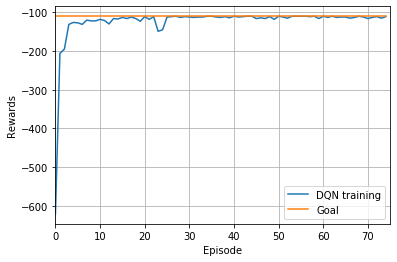

In [4]:
plt.subplots(figsize= (6, 4))
plt.plot(list(range(len(loss))), loss, label = 'DQN training')
plt.plot(list(range(len(loss))), np.ones((len(loss), 1))* -110, label = 'Goal')
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.legend(loc = 'lower right')
plt.xlim(0, len(loss))
plt.grid(True)
plt.show()